In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict

import pandas as pd
import seaborn as sns
import numpy as np

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix

from gmfpp.utils.data_preparation import *
from gmfpp.utils.data_transformers import *
from gmfpp.utils.plotting import *
from gmfpp.utils.profiling import *

from gmfpp.models.ReparameterizedDiagonalGaussian import *
from gmfpp.models.CytoVariationalAutoencoder import CytoVariationalAutoencoder
from gmfpp.models.VariationalAutoencoder import VariationalAutoencoder
from gmfpp.models.ConvVariationalAutoencoder import ConvVariationalAutoencoder
from gmfpp.models.VariationalInference import VariationalInference
from gmfpp.models.VariationalInference_nonvar import VariationalInference_nonvar
from gmfpp.models.LoadModels import *

In [2]:
datetime=get_datetime()
create_directory("dump/logs")
logfile = open("./dump/logs/log_{}.log".format(datetime), "w")
logfile=None

In [3]:
def constant_seed(seed: int = 0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
constant_seed()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cprint(f"Using device: {device}", logfile)

15:39:34 | Using device: cpu


## Load data

In [5]:
data_root = "./data/all/"
metadata_all = read_metadata(data_root + "metadata.csv")



In [6]:
metadata_all.groupby(['moa'])['moa'].count()

moa
Actin disruptors               7491
Aurora kinase inhibitors      16810
Cholesterol-lowering           5436
DMSO                         276360
DNA damage                    16582
DNA replication                5976
Eg5 inhibitors                12525
Epithelial                    14955
Kinase inhibitors             11622
Microtubule destabilizers     15178
Microtubule stabilizers       89157
Protein degradation            6589
Protein synthesis              9715
Name: moa, dtype: int64

In [7]:
metadata = shuffle_metadata(metadata_all)[:100000]
mapping = get_MOA_mappings(metadata)
metadata_train_all, metadata_test = split_metadata(metadata, split_fraction = .90)
metadata_train, metadata_validation = split_metadata(metadata_train_all, split_fraction = .90)

In [8]:
relative_path = get_relative_image_paths(metadata)
image_paths = [data_root + path for path in relative_path]

In [9]:
images = load_images(image_paths, verbose=True, log_every=10000)

15:39:37 | loaded 0/100000 images (0.00%).
15:39:41 | loaded 10000/100000 images (10.00%).
15:39:44 | loaded 20000/100000 images (20.00%).
15:39:48 | loaded 30000/100000 images (30.00%).
15:39:52 | loaded 40000/100000 images (40.00%).
15:39:56 | loaded 50000/100000 images (50.00%).
15:40:00 | loaded 60000/100000 images (60.00%).
15:40:03 | loaded 70000/100000 images (70.00%).
15:40:07 | loaded 80000/100000 images (80.00%).
15:40:11 | loaded 90000/100000 images (90.00%).
15:40:15 | loaded 100000/100000 images (100.00%).


## Normalize data

In [10]:
normalize_channels_inplace(images)
print(images.shape)

torch.Size([100000, 3, 68, 68])


## Split data

In [11]:
train_set = SingleCellDataset(metadata_train, images, mapping)
validation_set = SingleCellDataset(metadata_validation, images, mapping)
test_set = SingleCellDataset(metadata_test, images, mapping)

## Load trained model

In [12]:

#vae, validation_data, training_data, VAE_settings = LoadVAEmodel("model_dump",'2022-11-23 - 22-21-58')
model_type  = "nonvar"
vae, validation_data, training_data, VAE_settings = LoadVAEmodel("./dump/outputs_2022-12-04 - 12-20-15/", model_type)

In [13]:
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=VAE_settings['learning_rate'], weight_decay=VAE_settings['weight_decay'])

vi = VariationalInference_nonvar(beta=VAE_settings['beta'])

In [14]:
train_loader = DataLoader(train_set, batch_size=VAE_settings['batch_size'], shuffle=True, num_workers=0, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=VAE_settings['batch_size'], shuffle=False, num_workers=0, drop_last=False)


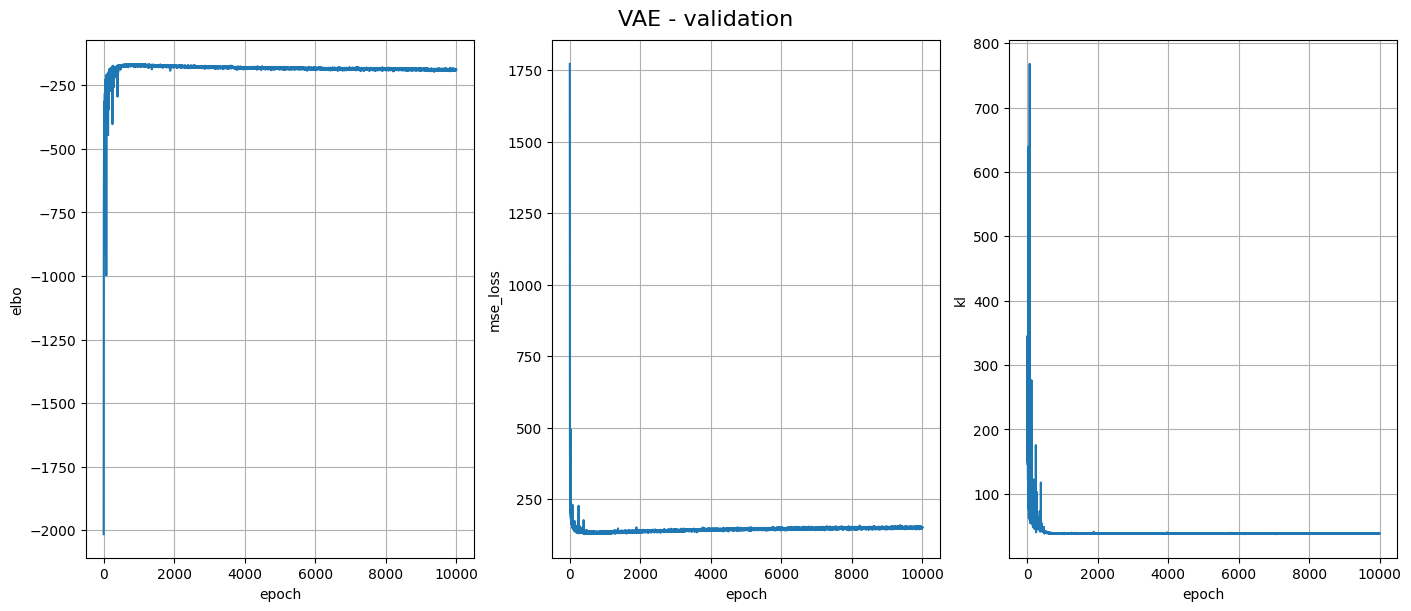

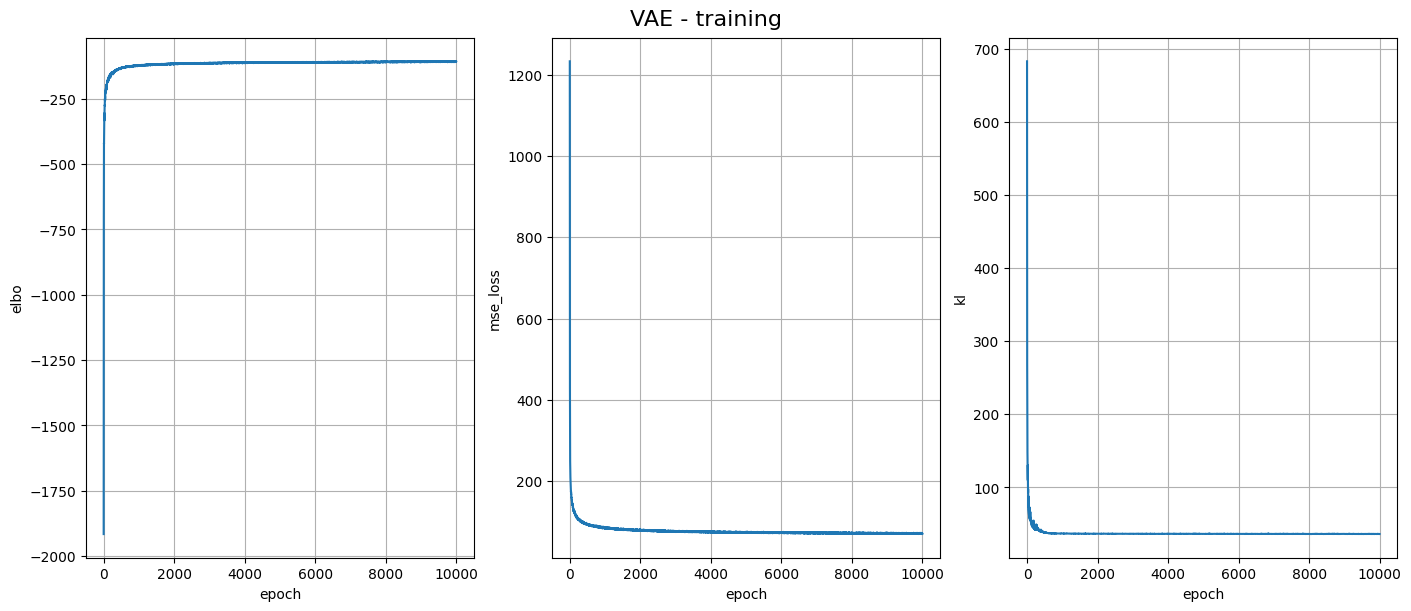

In [15]:
plot_VAE_performance(validation_data, title='VAE - validation')
plot_VAE_performance(training_data, title='VAE - training')



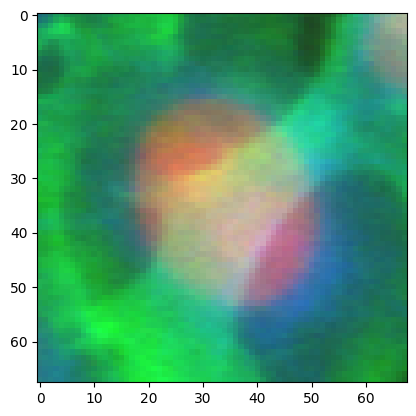

In [16]:
x, y = test_set[1]
plot_image(img_saturate(x))

In [17]:
def sample_from_latent(latent: torch.Tensor, vae: nn.Module):
    px = vae.observation_model(latent)
    x_reconstruction = px.sample()
    return x_reconstruction

In [18]:
vae.eval() # because of batch normalization
outputs = vae(x[None,:,:,:])
x_reconstruction = outputs["x_hat"].detach()
x_reconstruction = x_reconstruction[0]

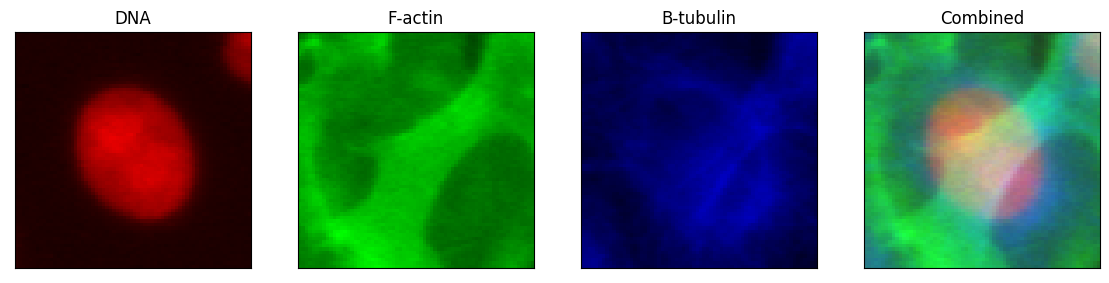

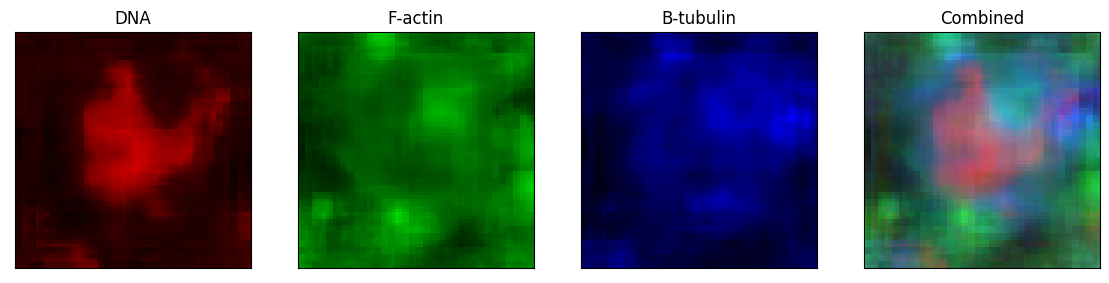

In [19]:
plot_image_channels(img_saturate(x))
plot_image_channels(img_saturate(x_reconstruction))

In [20]:
x0 = train_set[0][0]
x1 = train_set[10][0]
print(type(x0))

<class 'torch.Tensor'>


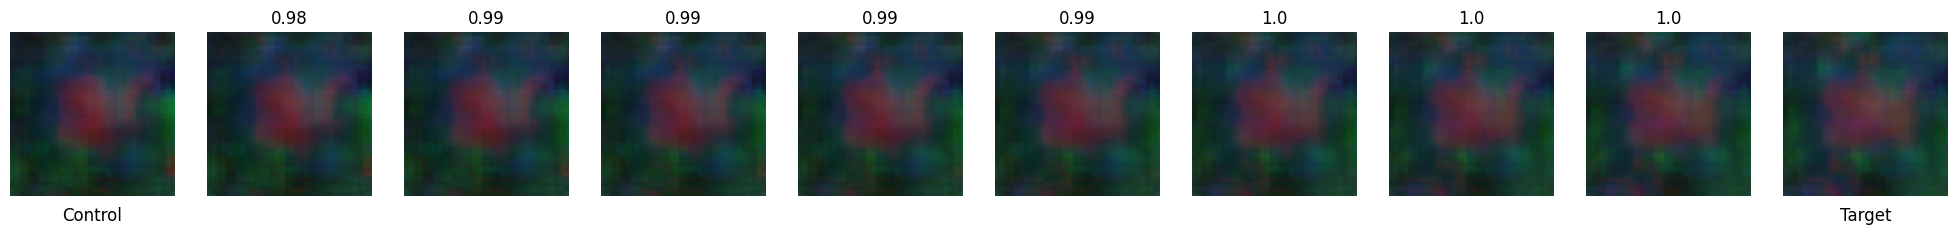

In [21]:
model = vae
plot_cosine_similarity(x0, x1, model, file=None, title=None)

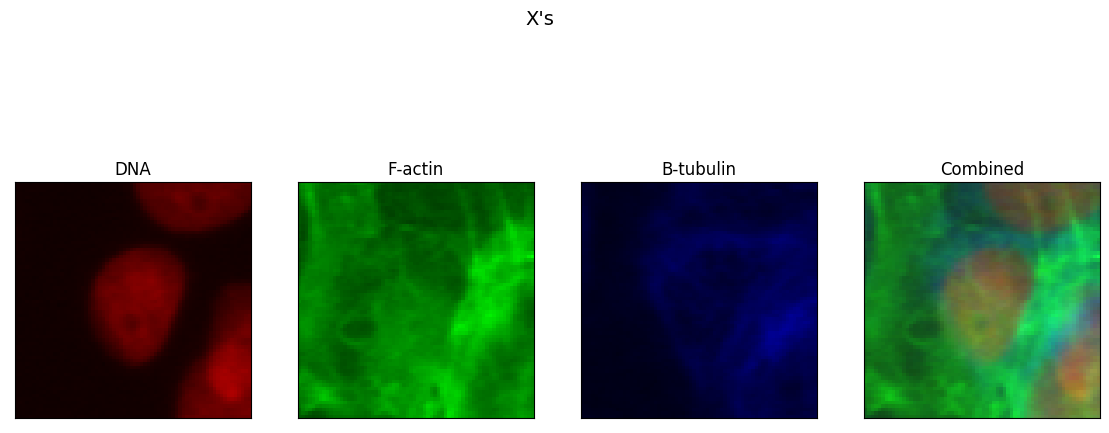

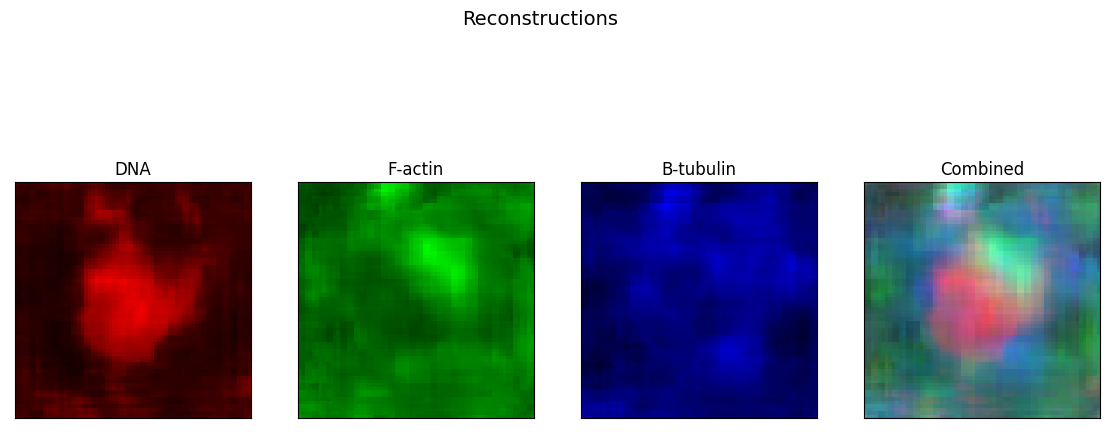

In [22]:
n = 1
for i in range(10,n+10):
    x, y = train_set[i]    
    #x = x.to(device)
    
    plot_image_channels(img_saturate(x), title="X's")
   
    outputs = vae(x[None,:,:,:])
    
    x_reconstruction = outputs["x_hat"].detach()
    x_reconstruction = x_reconstruction[0]
    plot_image_channels(img_saturate(x_reconstruction), title="Reconstructions")


## Latent space heatmap
1) one-hot-encoding of a variable
2) calculate correlation matrix between the hot-encoded variables and latent space variables
3) plot it out nocely

In [23]:
# extracting latent variables for each image/cell
def LatentVariableExtraction(metadata, images, batch_size, vae):
    images.shape[0]
    batch_size=min(batch_size, len(images))
    batch_offset = np.arange(start=0, stop=images.shape[0]+1, step=batch_size)

    df = pd.DataFrame()
    new_metadata = pd.DataFrame()

    for j, item in enumerate(batch_offset[:-1]):
        start = batch_offset[j]
        end = batch_offset[j+1]

        outputs = vae(images[start:end,:,:,:])
        z = outputs["z"]
        z_df = pd.DataFrame(z.detach().numpy())
        z_df.index = list(range(start,end))
        df = pd.concat([metadata.iloc[start:end], z_df], axis=1)
        new_metadata = pd.concat([new_metadata, df], axis=0)
        print("Profiling {}/{} batches of size {}".format(j, len(batch_offset)-1, batch_size))
    return new_metadata

In [24]:
metadata['Well_unique'] = metadata['Image_Metadata_Well_DAPI'] + '_' + metadata['Image_Metadata_Plate_DAPI']
metadata['Treatment'] = metadata['Image_Metadata_Compound'] + '_' + metadata['Image_Metadata_Concentration'].astype(str)
metadata['week'] = metadata['Image_PathName_DAPI'].str.split("_", n=1, expand = True)[0]
metadata['row_id'] = np.arange(len(metadata))
metadata_latent = LatentVariableExtraction(metadata, images, 1000, vae)

Profiling 0/100 batches of size 1000
Profiling 1/100 batches of size 1000
Profiling 2/100 batches of size 1000
Profiling 3/100 batches of size 1000
Profiling 4/100 batches of size 1000
Profiling 5/100 batches of size 1000
Profiling 6/100 batches of size 1000
Profiling 7/100 batches of size 1000
Profiling 8/100 batches of size 1000
Profiling 9/100 batches of size 1000
Profiling 10/100 batches of size 1000
Profiling 11/100 batches of size 1000
Profiling 12/100 batches of size 1000
Profiling 13/100 batches of size 1000
Profiling 14/100 batches of size 1000
Profiling 15/100 batches of size 1000
Profiling 16/100 batches of size 1000
Profiling 17/100 batches of size 1000
Profiling 18/100 batches of size 1000
Profiling 19/100 batches of size 1000
Profiling 20/100 batches of size 1000
Profiling 21/100 batches of size 1000
Profiling 22/100 batches of size 1000
Profiling 23/100 batches of size 1000
Profiling 24/100 batches of size 1000
Profiling 25/100 batches of size 1000
Profiling 26/100 batch

In [25]:
metadata_onehot = pd.concat([metadata_latent, pd.get_dummies(metadata_latent["moa"], prefix = 'onehot_moa')], axis=1)

In [26]:
latent_cols = [col for col in metadata_onehot.columns if type(col)==int]
one_hot_cols = [col for col in metadata_onehot.columns if type(col)==str and col[0:7]=='onehot_']


In [27]:
heatmap_matrix = metadata_onehot[one_hot_cols + latent_cols].corr().filter(items=one_hot_cols, axis=0)[latent_cols]


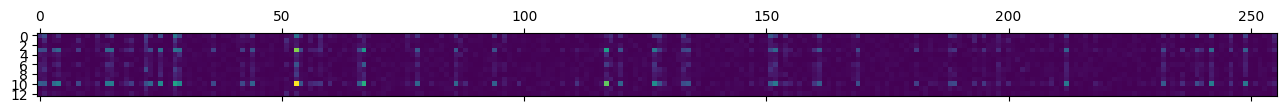

In [28]:
plt.matshow(heatmap_matrix.abs())

<AxesSubplot:>

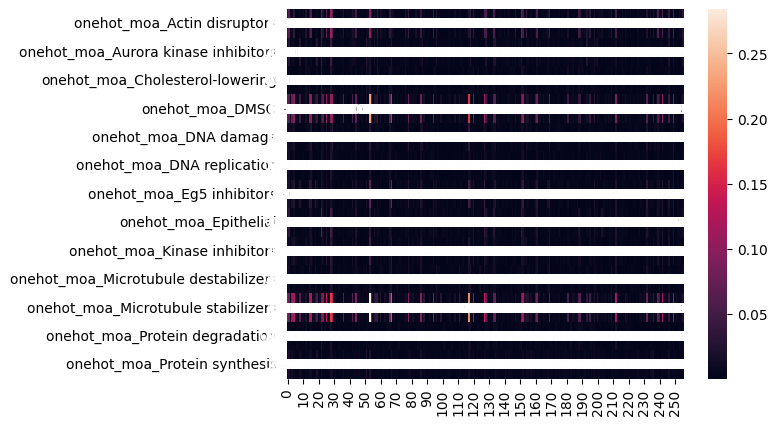

In [29]:
sns.heatmap(heatmap_matrix.abs(), annot=True)

## Nearest neighbour classification
### NSC Not-Same-Compound:
1) A = Take a subset consisting of all cells form one compound.
2) B = Take the rest
3) For each element in A, find their closest neighbor in B
4) Use the moa class label from B as the predicted class label for elements in A

### NSCB Not-Same-Compound-and-Batch:
1) A = Take a subset consisting of all cells form one plate.
2) B = Take the rest
3) For each element in A, find their closest neighbor in B
4) Use the moa class label from B as the predicted class label for elements in A


In [30]:
from sklearn.neighbors import NearestNeighbors


In [31]:
#model on all observations
metadata_latent_latent_cols = metadata_latent[latent_cols]
metadata.columns


Index(['Unnamed: 0', 'Multi_Cell_Image_Id', 'Multi_Cell_Image_Name',
       'Single_Cell_Image_Id', 'Single_Cell_Image_Name', 'TableNumber',
       'ImageNumber', 'Image_FileName_DAPI', 'Image_PathName_DAPI',
       'Image_FileName_Tubulin', 'Image_PathName_Tubulin',
       'Image_FileName_Actin', 'Image_PathName_Actin',
       'Image_Metadata_Plate_DAPI', 'Image_Metadata_Well_DAPI', 'Replicate',
       'Image_Metadata_Compound', 'Image_Metadata_Concentration', 'moa',
       'Well_unique', 'Treatment', 'week', 'row_id'],
      dtype='object')

In [32]:
metadata['NSC_class']=''

In [ ]:
NSC_var = 'week'
class_var = 'moa'

for myNSC_var in metadata_latent[NSC_var].unique():
    print("\nBegging myclass: ", myNSC_var)
    class_rows_list = metadata[metadata_latent[NSC_var] == myNSC_var]['row_id'].to_list()
    class_subset = metadata_latent[latent_cols][metadata_latent[NSC_var] == myNSC_var]
    anti_set = metadata_latent[latent_cols][metadata_latent[NSC_var] != myNSC_var]
    print("fitting to antiset")
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(anti_set)
    print("classifying")
    myclassification = nbrs.kneighbors(class_subset, 1, return_distance=False)
    myclassification_list = list(myclassification[:,0])
    for classification_row_id , metadata_row_id in enumerate(class_rows_list):
        myclass = metadata.filter(items = [myclassification_list[classification_row_id]], axis=0)[class_var].tolist()[0]
        metadata.at[metadata_row_id, 'NSC_class'] = myclass
        metadata.at[metadata_row_id, 'nearest_neighbor_NSC'] = myclassification_list[classification_row_id]
    print("\nFinished myclass: ", myclass)
    



Begging myclass:  Week7
fitting to antiset
classifying

Finished myclass:  Microtubule stabilizers

Begging myclass:  Week1
fitting to antiset
classifying


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cf_matrix=confusion_matrix(metadata['moa'], metadata['NSC_class'])  
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in mapping],
                     columns = [i for i in mapping])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)


## Nearest neighbour classification
1) Get profile from well
2) Get profile from unique treatment

### NSC Not-Same-Compound:
1) A = Take all the treatment-profiles with the chosen compound. 
2) B = Take the rest of the treatment-profiles.
3) For each element in A, find their closest neighbor in B
4) Use the moa class label from B as the predicted class label for elements in A

### NSCB Not-Same-Compound-and-Batch:
1) A = Take all the treatment-profiles with the chosen week & compound.
3) B = Take all treatment-profiles that are from other weeks and from other compound.
4) For each element in A, find their closest neighbor in B.
5) Use the moa class label from B as the predicted class label for elements in A
